<a href="https://colab.research.google.com/github/talpt/pyton/blob/main/Maestro_NadarayaBant_Price_Crossover.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  Cloning https://github.com/rongardF/tvdatafeed to /tmp/pip-req-build-_4kmhod5
  Running command git clone --filter=blob:none --quiet https://github.com/rongardF/tvdatafeed /tmp/pip-req-build-_4kmhod5
  Resolved https://github.com/rongardF/tvdatafeed to commit e6f6aaa7de439ac6e454d9b26d2760ded8dc4923
  Preparing metadata (setup.py) ... done


Lütfen pencere uzunluğunu girin (örneğin 300): 300
Lütfen bir zaman dilimi seçin:
1: 15 Dakika
2: 30 Dakika
3: 45 Dakika
4: 1 Saat
5: 2 Saat
6: 4 Saat
7: Günlük
8: Haftalık
9: Aylık
Seçiminizi yapın (1-9): 7
Günlük seçildi.
Tarama tipi seçin:
1: Alt kanal kesişimi
2: Üst kanal kesişimi
3: Orta kanal kesişimi
Seçiminizi yapın (1-3): 3
ALCTL orta kanal kesişimi sağlandı. Son Fiyat: 115.8, Kesişim Zamanı: 2024-10-28 06:00:00, Periyot: Günlük
ALKIM orta kanal kesişimi sağlandı. Son Fiyat: 33.2, Kesişim Zamanı: 2024-10-28 06:00:00, Periyot: Günlük
BANVT orta kanal kesişimi sağlandı. Son Fiyat: 375.0, Kesişim Zamanı: 2024-10-28 06:00:00, Periyot: Günlük
CIMSA orta kanal kesişimi sağlandı. Son Fiyat: 32.98, Kesişim Zamanı: 2024-10-28 06:00:00, Periyot: Günlük
CWENE orta kanal kesişimi sağlandı. Son Fiyat: 180.8, Kesişim Zamanı: 2024-10-28 06:00:00, Periyot: Günlük
DMSAS orta kanal kesişimi sağlandı. Son Fiyat: 6.47, Kesişim Zamanı: 2024-10-28 06:00:00, Periyot: Günlük
FORTE orta kanal kesişim

ERROR:tvDatafeed.main:Connection to remote host was lost.
ERROR:tvDatafeed.main:no data, please check the exchange and symbol


VKGYO orta kanal kesişimi sağlandı. Son Fiyat: 1.81, Kesişim Zamanı: 2024-10-28 06:00:00, Periyot: Günlük
YEOTK orta kanal kesişimi sağlandı. Son Fiyat: 182.6, Kesişim Zamanı: 2024-10-28 06:00:00, Periyot: Günlük

Kanal kesişimi yapan hisseler:
+----+-------------+-------------+--------------+---------------------+-----------+
|    | Hisse Adı   |   Son Fiyat | Kanal Tipi   | Kesişim Zamanı      | Periyot   |
+====+=============+=============+==============+=====================+===========+
|  0 | ALCTL       |      115.8  | Orta Kanal   | 2024-10-28 06:00:00 | Günlük    |
+----+-------------+-------------+--------------+---------------------+-----------+
|  1 | ALKIM       |       33.2  | Orta Kanal   | 2024-10-28 06:00:00 | Günlük    |
+----+-------------+-------------+--------------+---------------------+-----------+
|  2 | BANVT       |      375    | Orta Kanal   | 2024-10-28 06:00:00 | Günlük    |
+----+-------------+-------------+--------------+---------------------+-----------+

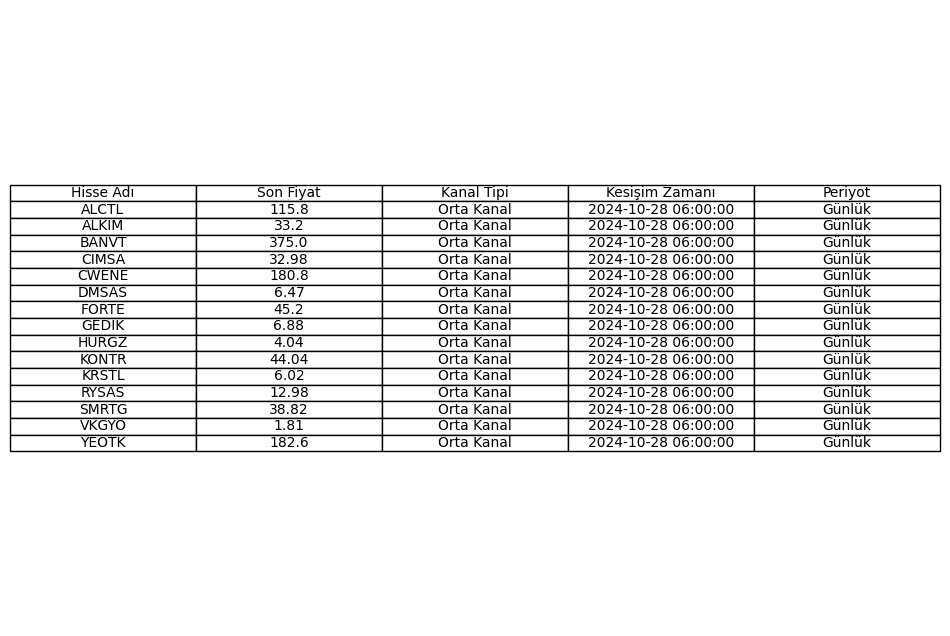

In [ ]:
# Kütüphaneler
!pip install git+https://github.com/rongardF/tvdatafeed matplotlib openpyxl ta
!pip install tradingview-screener==2.5.0

import pandas as pd
import numpy as np
from tvDatafeed import TvDatafeed, Interval
from tradingview_screener import get_all_symbols
import warnings
import matplotlib.pyplot as plt
from tabulate import tabulate

warnings.simplefilter(action='ignore', category=FutureWarning)

# TvDatafeed nesnesi oluşturma
tv = TvDatafeed()

# Türkiye piyasasındaki tüm sembolleri almak için
try:
    Hisseler = get_all_symbols(market='turkey')
    Hisseler = [symbol.replace('BIST:', '') for symbol in Hisseler]
    Hisseler = sorted(Hisseler)
except Exception as e:
    print(f"Hata alındı: {e}")

# Lineer regresyon fonksiyonu
def linreg(series, length):
    x = np.arange(length)
    def linear_regression(y):
        A = np.vstack([x, np.ones(len(x))]).T
        m, c = np.linalg.lstsq(A, y, rcond=None)[0]
        return m * x[-1] + c
    return series.rolling(length).apply(linear_regression, raw=False)

# Kullanıcının zaman dilimini seçmesini sağlayan fonksiyon
def get_interval_choice():
    intervals = {
        '1': ('15 Dakika', Interval.in_15_minute),
        '2': ('30 Dakika', Interval.in_30_minute),
        '3': ('45 Dakika', Interval.in_45_minute),
        '4': ('1 Saat', Interval.in_1_hour),
        '5': ('2 Saat', Interval.in_2_hour),
        '6': ('4 Saat', Interval.in_4_hour),
        '7': ('Günlük', Interval.in_daily),
        '8': ('Haftalık', Interval.in_weekly),
        '9': ('Aylık', Interval.in_monthly)
    }

    print("Lütfen bir zaman dilimi seçin:")
    for key, value in intervals.items():
        print(f"{key}: {value[0]}")

    choice = input("Seçiminizi yapın (1-9): ")

    if choice in intervals:
        print(f"{intervals[choice][0]} seçildi.")
        return intervals[choice][1], intervals[choice][0]  # Hem interval hem de adı döndür
    else:
        print("Geçersiz seçim. Varsayılan olarak günlük (1D) seçildi.")
        return Interval.in_daily, 'Günlük'

# Tarama tipini kullanıcıdan almak
def get_scan_type():
    print("Tarama tipi seçin:")
    print("1: Alt kanal kesişimi")
    print("2: Üst kanal kesişimi")
    print("3: Orta kanal kesişimi")

    scan_choice = input("Seçiminizi yapın (1-3): ")

    if scan_choice == '1':
        return 'lower'
    elif scan_choice == '2':
        return 'upper'
    elif scan_choice == '3':
        return 'middle'
    else:
        print("Geçersiz seçim. Varsayılan olarak alt kanal kesişimi seçildi.")
        return 'lower'

# Uzunluk değerini kullanıcıdan almak
length = int(input("Lütfen pencere uzunluğunu girin (örneğin 300 ): "))

# Zaman dilimini kullanıcıdan almak
interval, interval_name = get_interval_choice()

# Tarama tipini kullanıcıdan almak
scan_type = get_scan_type()

results = []

# Her sembol için döngü
for symbol in Hisseler:
    try:
        # TradingView'dan veri çekme
        data = tv.get_hist(symbol=symbol, exchange='BIST', interval=interval, n_bars=1000)
        if data is None or data.empty:
            continue

        # Linear Regression ve Deviation hesaplama
        data['linreg'] = linreg(data['close'], length)
        data['deviation'] = data['close'].rolling(window=length).std() * 3  # Multiplication factor for deviation

        data['upper_band'] = data['linreg'] + data['deviation']
        data['lower_band'] = data['linreg'] - data['deviation']

        # Kesişim kontrolleri
        data['cross_up'] = (data['close'].shift(1) < data['lower_band'].shift(1)) & (data['close'] > data['lower_band'])
        data['cross_down'] = (data['close'].shift(1) > data['upper_band'].shift(1)) & (data['close'] < data['upper_band'])
        data['cross_mid'] = (data['close'].shift(1) < data['linreg'].shift(1)) & (data['close'] > data['linreg'])

        # Tarama tipine göre filtreleme
        if scan_type == 'lower' and data.iloc[-1]['cross_up']:
            result_message = f"{symbol} alt kanal kesişimi sağlandı. Son Fiyat: {data.iloc[-1]['close']}, Kesişim Zamanı: {data.index[-1]}, Periyot: {interval_name}"
            print(result_message)
            results.append({
                'Hisse Adı': symbol,
                'Son Fiyat': data.iloc[-1]['close'],
                'Kanal Tipi': 'Alt Kanal',
                'Kesişim Zamanı': data.index[-1],
                'Periyot': interval_name
            })
        elif scan_type == 'upper' and data.iloc[-1]['cross_down']:
            result_message = f"{symbol} üst kanal kesişimi sağlandı. Son Fiyat: {data.iloc[-1]['close']}, Kesişim Zamanı: {data.index[-1]}, Periyot: {interval_name}"
            print(result_message)
            results.append({
                'Hisse Adı': symbol,
                'Son Fiyat': data.iloc[-1]['close'],
                'Kanal Tipi': 'Üst Kanal',
                'Kesişim Zamanı': data.index[-1],
                'Periyot': interval_name
            })
        elif scan_type == 'middle' and data.iloc[-1]['cross_mid']:
            result_message = f"{symbol} orta kanal kesişimi sağlandı. Son Fiyat: {data.iloc[-1]['close']}, Kesişim Zamanı: {data.index[-1]}, Periyot: {interval_name}"
            print(result_message)
            results.append({
                'Hisse Adı': symbol,
                'Son Fiyat': data.iloc[-1]['close'],
                'Kanal Tipi': 'Orta Kanal',
                'Kesişim Zamanı': data.index[-1],
                'Periyot': interval_name
            })

    except Exception as e:
        print(f"Hata alındı {symbol}: {e}")

# Sonuçları tablo olarak gösterme
if results:
    df_results = pd.DataFrame(results)
    print("\nKanal kesişimi yapan hisseler:")
    print(tabulate(df_results, headers='keys', tablefmt='grid'))

    # Görsel olarak tabloyu gösterme
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.axis('tight')
    ax.axis('off')
    ax.table(cellText=df_results.values, colLabels=df_results.columns, cellLoc='center', loc='center')
    plt.show()
else:
    print("\nHiçbir hisse belirtilen kanal kesişim koşulunu sağlamıyor.")
